In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


### Load Model and Data

In [2]:
model_path = '/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/QNLI_09_56_46/best_model.pth'
#'/lfs/1/mccreery/repos/metal/logs/checkpoints/18-2-2019/COLA_15_11_24/best_model.pth'
task_name = 'QNLI' #'COLA'
split = 'dev'

#Load model and data
model,dl = load_data_and_model(model_path,task_name,split)

#Create DataFrame of Raw Data, Predictions, and Labels
print('creating dataframe')
df_error = create_dataframe(task_name,model,dl)
print('created dataframe')
df_error.head()

#Save (and reload) DataFrame
csv_path = '/'.join(model_path.split('/')[0:-1])
filepath = f'{task_name}_{split}_error_analysis.tsv'
save_dataframe(df_error,filepath)
df_error = load_dataframe(filepath)


Using random seed: 704120.
Loading QNLI Dataset



creating dataframe


 58%|█████▊    | 100/171 [00:12<00:10,  6.89it/s]

created dataframe
Saved dataframe to:  QNLI_dev_error_analysis.tsv


## Sandbox for Error Analysis

**0. Some basic statistics.**

Confusion Matrix and Performance Metrics

In [3]:
from metal.analysis import confusion_matrix
#TODO: change to use the right function for label space change (0,1) to (1,2)
confusion_matrix( df_error['label']+1.,1*(df_error['score']>0.5)+1., pretty_print=True)
print()

from metal.metrics import metric_score
metric_list = ['accuracy','precision', 'recall', 'f1']

for metric in metric_list:
    score = metric_score(df_error['label']+1., 1*(df_error['score']>0.5)+1., metric, probs=df_error['score'])
    print(f"{metric.capitalize()}: {score:.3f}")

        y=1    y=2   
 l=1   1349    264   
 l=2    277   1342   

Accuracy: 0.833
Precision: 0.836
Recall: 0.830
F1: 0.833


Plotting Predictions and Predicted Probabilistic Label Distribution

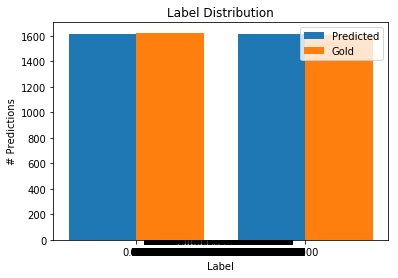

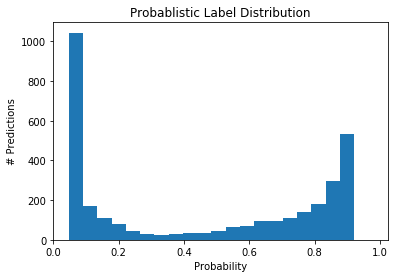

In [4]:
from metal.contrib.visualization.analysis import (
        plot_predictions_histogram, 
        plot_probabilities_histogram,
    )

plot_predictions_histogram(df_error['score'], df_error['label'], title="Label Distribution")
plot_probabilities_histogram(df_error['score'], title="Probablistic Label Distribution")

**1. We want to look at examples that are "barely" wrong and "barely" right since we have hope for boosts here.**

In [5]:
print("\033[1mBARELY WRONG\033[0;0m")
for i in range(3):
    print_barely_pred(df_error,is_incorrect=True,thresh=0.2)
    
print("\033[1mBARELY RIGHT\033[0;0m")
for i in range(3):
    print_barely_pred(df_error,is_incorrect=False,thresh=0.15)

BARELY WRONG
ID:  3213
sentence1: 	 what han chinese leader defected to the mongols ? 
sentence2: 	 many han chinese and k ##hita ##n defected to the mongols to fight against the jin . 
score: 	0.8741
label: 	0

ID:  833
sentence1: 	 where did hug ##uen ##ots and wall ##oons settle in england ? 
sentence2: 	 other evidence of the wall ##oons and hug ##uen ##ots in canterbury includes a block of houses in turn ##aga ##in lane , where weaver ##s ' windows survive on the top floor , as many hug ##uen ##ots worked as weaver ##s . 
score: 	0.0832
label: 	1

ID:  852
sentence1: 	 which pair of gen ##ghi ##s khan ' s sons were most rival ##rous ? 
sentence2: 	 gen ##ghi ##s khan was aware of the friction between his sons ( particularly between cha ##gata ##i and jo ##chi ) and worried of possible conflict between them if he died . 
score: 	0.1199
label: 	1

BARELY RIGHT
ID:  617
sentence1: 	 who shared side ##line reporting duties with mark malone ? 
sentence2: 	 westwood one will carry the g

**2. We also want to look at examples we got completely wrong since that could point to a systematic bias in the data/model. It could also help us find examples in the dataset that are mislabeled by human annotators**

In [6]:
print("\033[1mVERY WRONG\033[0;0m")
for i in range(3):
    print_very_wrong_pred(df_error,thresh=0.9)

VERY WRONG
ID:  3161
sentence1: 	 by justification certain racial and geographical theories , europe thought of itself as what ? 
sentence2: 	 according to si ##ad , oriental ##ism allowed europe to establish itself as the superior and the norm , which justified its dominance over the essential ##ized orient . 
score: 	0.0928
label: 	1

ID:  811
sentence1: 	 where are the harvard medical , dental and school of public health located ? 
sentence2: 	 the harvard medical school , harvard school of dental medicine , and the harvard school of public health are located on a 21 - acre ( 8 . 5 ha ) 
score: 	0.9089
label: 	0

ID:  3053
sentence1: 	 what show did peter jennings anchor for abc ? 
sentence2: 	 the abc news building was renamed peter jennings way in 2006 in honor of the recently deceased longtime abc news chief anchor and anchor of world news tonight . 
score: 	0.0861
label: 	1



**3. To find systematic errors, we can also look for correlations between certain features and the incorrectness a la Socratic**


We can make this way more sophisticated by perhaps using embeddings instead of this simple [BoW featurization](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer).

In [7]:
print("\033[1mSYSTEMATIC EXAMPLES\033[0;0m")
for i in range(3):
    print_systematic_wrong(df_error)

SYSTEMATIC EXAMPLES


/dfs/scratch0/vschen/venv-mmtl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


final score
prior super bowl 50
des ri
defensive coordinator
slave trade

sentence1: 	 how many africans were brought into the united states during the slave trade ? 
sentence2: 	 participation in the african slave trade and the subsequent treatment of its 12 to 15 million africans is viewed by some to be a more modern extension of america ' s " internal colonial ##ism " . 
score: 	0.0637
label: 	1



/dfs/scratch0/vschen/venv-mmtl/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


final score
prior super bowl 50
defensive coordinator
slave trade
des ri

sentence1: 	 what was the final score of the afc championship game ? 
sentence2: 	 they then beat the defending super bowl xl ##ix champion new england patriots in the afc championship game , 20 – 18 , by intercept ##ing a pass on new england ' s 2 - point conversion attempt with 17 seconds left on the clock . 
score: 	0.4080
label: 	1

final score
prior super bowl 50
och ond ria
composer used
defensive coordinator

sentence1: 	 what composer used luther ' s hymns in his works ? 
sentence2: 	 johann sebastian bach included several verses as chorale ##s in his cantata ##s and based chorale cantata ##s entirely on them , namely christ la ##g in tod ##es band ##en , bwv 4 , as early as possibly 1707 , in his second annual cycle ( 1724 to 1725 ) 
score: 	0.3770
label: 	1



## Designing Labeling Functions

**1. Number Based LF**

Our model tends to fail when there are numbers involved in the two sentences. We can look for the same number being repeated in both sentences as an LF

In [8]:
def LF_number(idx):
    sentence1_nums = [int(s) for s in df_error['sentence1'][idx].split() if s.isdigit()]
    sentence2_nums = [int(s) for s in df_error['sentence2'][idx].split() if s.isdigit()]
    common_nums = len(set(sentence1_nums).intersection(set(sentence2_nums)))
    
    if (sentence1_nums == []) or (sentence2_nums == []):
        return 0
    
    if common_nums > 0:
        return 2
    else:
        return 1

In [9]:
print_row(df_error.iloc[70])
print("LF_label: ", LF_number(70)-1)

print()
print()
print_row(df_error.iloc[254])
print("LF_label: ", LF_number(254)-1)

sentence1: 	 what was the name of the imperial ##istic policy in china ? 
sentence2: 	 the age of imperialism , a time period beginning around 1700 , saw ( generally european ) industrial ##izing nations engaging in the process of colon ##izing , influencing , and annex ##ing other parts of the world in order to gain political power . [ citation needed ] 
score: 	0.0876
label: 	0

LF_label:  -1


sentence1: 	 what was he hoping to stimulate with the toe sq ##uis ##hing ? 
sentence2: 	 he sq ##uis ##hed his toes one hundred times for each foot every night , saying that it stimulated his brain cells . 
score: 	0.7898
label: 	1

LF_label:  -1


**2. Edit Distance Based LF**

Our model tends to vote entailment when one sentence is long and the other is short. We can focus on this slice and flip the labelt o vote no entailment even when the number of words is the same.

In [10]:
def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

from collections import Counter
def common_words(s1,s2):
    s1_set = set(Counter(s1.split()))
    s2_set = set(Counter(s2.split()))
    return len(s1_set.intersection(s2_set))/float(min(len(s1_set),len(s2_set)))

In [11]:
def LF_words(idx):
    ratio = common_words(df_error['sentence1'][idx], df_error['sentence2'][idx])
    if ratio < 0.3:
        return 1
    if (ratio <= 1.0) and (ratio > 0.4):
        return 2
    else:
        return 0

In [12]:
print_row(df_error.iloc[150])
print("LF_label: ", LF_words(150)-1)

print()
print()
print_row(df_error.iloc[95])
print("LF_label: ", LF_words(95)-1)

sentence1: 	 which regions have temperate climates ? 
sentence2: 	 according to geographic scholars under colon ##izing empires , the world could be split into climatic zones . 
score: 	0.0734
label: 	0

LF_label:  0


sentence1: 	 in what year did harvard stadium become the first ever concrete reinforced stadium in the country ? 
sentence2: 	 while harvard ' s football team is no longer one of the country ' s best as it often was a century ago during football ' s early days ( it won the rose bowl in 1920 ) , both it and yale have influenced the way the game is played . 
score: 	0.0616
label: 	0

LF_label:  0


### Analyze Labeling Functions

In [13]:
L = np.zeros((np.shape(df_error)[0],2))
for i in range(df_error.shape[0]):
    L[i,0] = LF_number(i)
    L[i,1] = LF_words(i)

Labeling Function Summary

In [14]:
from metal.analysis import lf_summary
from scipy.sparse import csr_matrix    

L_sparse = csr_matrix(L)
lf_summary(L_sparse,Y=df_error.label+1)

,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
0,"[1.0, 2.0]",0.087562,0.07271,0.011448,217,66,0.766784
1,"[1.0, 2.0]",0.806931,0.07271,0.011448,2022,586,0.775307


In [15]:
incorrect = set(np.where(df_error.is_wrong == True)[0])
LF1_set = set(np.where(L[:,0]-1. == df_error.label)[0])
LF2_set = set(np.where(L[:,1]-1. == df_error.label)[0])

print("Percentage Corrected by LF_num: ", 100.*len(LF1_set.intersection(incorrect))/float(len(incorrect)))
print("Percentage Corrected by LF_words: ", 100.*len(LF2_set.intersection(incorrect))/float(len(incorrect)))

Percentage Corrected by LF_num:  5.545286506469501
Percentage Corrected by LF_words:  28.650646950092423
